# Challenge Set 4<br >
Topic:        Linear Splitting<br >
Date:         07/26/2016<br >
Name:         Seth Kaufman

In [1]:
import numpy as np
import scipy
from cycler import cycler
from patsy import dmatrices,dmatrix,design_info
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import brewer2mpl
import seaborn as sns

plt.rcdefaults()

colors = brewer2mpl.wesanderson.Moonrise1.mpl_colors

rcParams['figure.dpi'] = (1000)
rcParams['axes.prop_cycle'] = (cycler('color', colors))
rcParams['lines.linewidth'] = 3
rcParams['patch.antialiased'] = True
rcParams['patch.edgecolor'] = 'none'

%matplotlib inline

### Linear Regression and Learning Curve challenges


##### Challenge 1

Generate (fake) data that is linearly related to `log(x)`.

You are making this model up. It is of the form `B0 + B1*log(x) + epsilon`. (You are making up the parameters.)

Simulate some data from this model.

Then fit two models to it:

 * quadratic (second degree polynomial)
 * logarithmic (`log(x)`)

(The second one should fit really well, since it has the same form as the underlying model!)

In [2]:
def log_model(x,b0,b1):
    return b0 + b1*np.log(x) 

In [3]:
s = 10**4
xdata = np.linspace(.1, 100, s)
epsilon = np.random.normal(0, 3, s)
log = log_model(xdata,10,-2)
ydata = log + epsilon

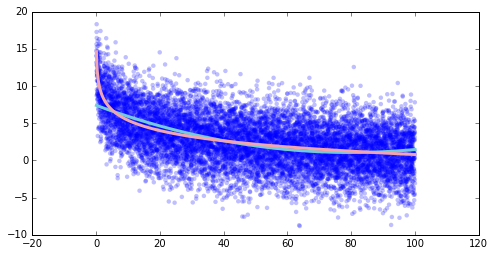

In [4]:
pfit = np.polyfit(xdata,ydata,deg=2)
logfit = scipy.optimize.curve_fit(log_model,xdata,ydata)

w,h = plt.figaspect(.5)
plt.figure(figsize=(w,h),dpi=1000)
plt.scatter(xdata,ydata, alpha=.25)
plt.plot(xdata, np.polyval(pfit,xdata), label='Poly Fit')
plt.plot(xdata,log, label='Log Fit')
plt.ylim(-10,20);

##### Challenge 2

Generate (fake) data from a model of the form `B0 + B1*x + B2*x^2 + epsilon`. (You are making up the parameters.)

Split the data into a training and test set.

Fit a model to your training set. Calculate mean squared error on your training set. Then calculate it on your test set.

(You could use `sklearn.metrics.mean_squared_error`.)








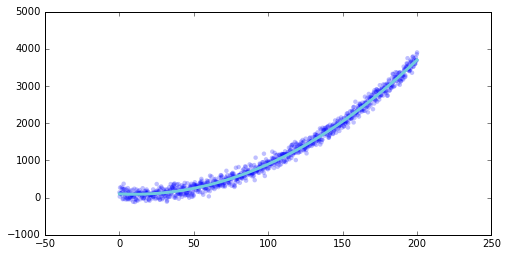

In [5]:
s = 10**3
epsilon = np.random.normal(0, 100, s)
xdata = np.linspace(0,200,s)
poly = np.polyval([.1,-2,100],xdata)
ydata = poly + epsilon

w,h = plt.figaspect(.5)
plt.figure(figsize=(w,h),dpi=1000)
plt.scatter(xdata,ydata,alpha=.25)
plt.plot(xdata,poly);

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata,train_size=.75)
results = sm.OLS(ytrain, xtrain).fit()
print('Training Set RMSE:', rmse(ytrain,results.predict(xtrain)))
print('Test Set RMSE:', rmse(ytest,results.predict(xtest)))
print(results.rsquared)

Training Set RMSE: 430.85045307
Test Set RMSE: 422.1400544
0.931912237759


##### Challenge 3

For the data from two (above), try polynomial fits from 0th (just constant) to 7th order (highest term x^7). Over the x axis of model degree (8 points), plot:

 * training error
 * test error
 * R squared
 * AIC



In [7]:
from collections import defaultdict
train = {"xtrain" : xtrain, "ytrain" : ytrain}
test = {"xtest":xtest,"ytest":ytest}

poly = defaultdict(list)
train_form = 'I(xtrain ** 0.0)'
test_form = 'I(xtest ** 0.0)'
for i,f in enumerate(range(8)):
    
    polytrain = smf.ols('ytrain ~ %s' % train_form , data=train).fit()
    new_xtest = dmatrix(test_form, data=test)    
    new_xtrain = dmatrix(train_form, data=train) 
    
    poly['training_err'].append(rmse(ytrain, polytrain.predict(new_xtrain,transform=False)))
    poly['test_err'].append(rmse(ytest, polytrain.predict(new_xtest,transform=False)))
    poly['r2'].append(polytrain.rsquared)
    poly['aic'].append(polytrain.aic)
    
    train_form += ' + I(xtrain ** %s.0)' % (i+1)
    test_form += '+ I(xtest ** %s.0)' % (i+1)

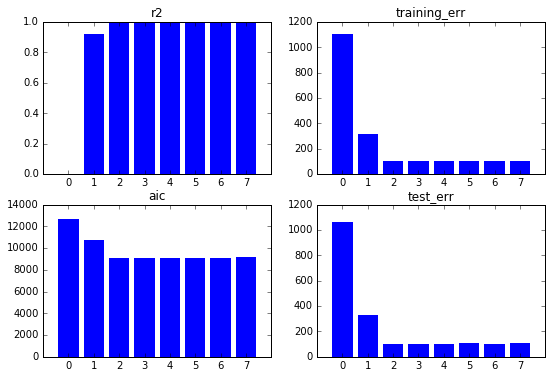

In [8]:
poly_fig = plt.figure(figsize=[9,6])
for i,(k,v) in enumerate(poly.items()):
    ax = poly_fig.add_subplot(2,2,i+1)
    ax.bar([0,1,2,3,4,5,6,7],v,label=k,align='center') 
    ax.set_ylim(bottom=0)
    ax.set_title(k,fontsize=12)
    ax.set_xticks(range(0,8))


##### Challenge 4

For the data from two (above), fit a model to only the first 5 of your data points (m=5). Then to first 10 (m=10). Then to first 15 (m=15). In this manner, keep fitting until you fit your entire training set. For each step, calculate the training error and the test error. Plot both (in the same plot) over m. This is called a learning curve.



In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata,train_size=.75,random_state=20)
traine = []
teste = []

for i in range(5,len(xtrain)+5,5):
    sx = xtrain[:i]
    sy = ytrain[:i]
    learning = sm.OLS(sy, sx).fit()
    traine.append(rmse(sy, learning.predict(sx)))
    teste.append(rmse(ytest, learning.predict(xtest)))

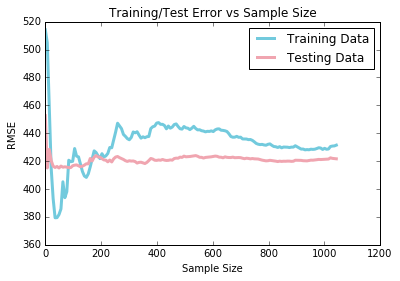

In [14]:
plt.plot(range(0,1050,7),traine,label='Training Data')
plt.plot(range(0,1050,7),teste,label='Testing Data')
plt.title('Training/Test Error vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend();